In [60]:
import os
import torch
import torchvision
from torch import nn
from torchvision import transforms
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import imageio.v3 as iio
import numpy as np
import matplotlib.pyplot as plt
import time
import math
import random
import nibabel as nib
from pathlib import Path
from pthflops import count_ops
from tqdm import tqdm
import h5py
print(torch.__version__)

2.0.0


In [29]:
f = h5py.File('recon_0.hdf5', 'r')
list(f.keys())

['cxy', 'cxyz', 'cxz', 'cyz']

In [63]:
img = f['cxy']
img = np.array(img)

In [33]:
img = np.stack((img[0, :, :], img[1, :, :]), axis=2)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


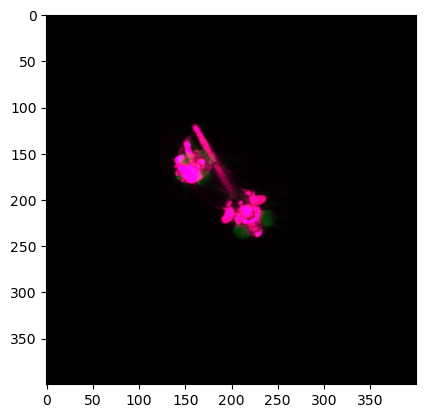

In [59]:
plt.imshow(np.stack((img[:, :, 0], img[:, :, 1], 0.5* img[:, :, 0]), axis=2))

In [6]:
print("Cuda available: ", torch.cuda.is_available())
if(torch.cuda.is_available()):
    torch.cuda.set_device("cuda:1")

    print("Is cuDNN version:", torch.backends.cudnn.version())

    print("cuDNN enabled:a", torch.backends.cudnn.enabled)

    print("Device count: ", torch.cuda.device_count())

    print("Current device: ", torch.cuda.current_device())

    print("Device name: ", torch.cuda.get_device_name(torch.cuda.current_device()))
#Setup device agnostic code (i.e use GPU if possible)
device = "cuda" if torch.cuda.is_available() else "cpu"
gpuNum = 1
print(device)

Cuda available:  False
cpu


In [18]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np

class GaussianSplatting3D(nn.Module):
    def __init__(self, grid_size, num_gaussians):
        super(GaussianSplatting3D, self).__init__()
        
        self.grid_size = grid_size
        self.num_gaussians = num_gaussians
        
        # Means for each Gaussian in 3D space
        self.mu = nn.Parameter(torch.randn(num_gaussians, 3))  # Means in 3D space
        # Standard deviations (sigma) for each Gaussian along each axis
        self.sigma = nn.Parameter(torch.rand(num_gaussians, 3) * 0.1)  # Initialize small

        # Amplitudes of the Gaussians
        self.amplitude = nn.Parameter(torch.rand(num_gaussians))

    def gaussian_kernel(self, x, mu, sigma):
        return torch.exp(-0.5 * ((x - mu) / sigma) ** 2)

    def forward(self, grid):
        # Flatten the grid to [H*W*T, 3] for batch processing
        grid_flat = grid.view(-1, 3)  # [H*W*T, 3]
        result = torch.zeros(grid_flat.size(0)).to(grid.device)
        
        # Iterate over all Gaussians
        for i in range(self.num_gaussians):
            # Compute Gaussian splat for each point in the grid
            dist = self.gaussian_kernel(grid_flat, self.mu[i], self.sigma[i])
            dist_prod = torch.prod(dist, dim=-1)  # Product across dimensions (x, y, z)
            
            # Accumulate weighted by the amplitude
            result += self.amplitude[i] * dist_prod

        return result.view(self.grid_size)  # Reshape to original 3D grid size

In [45]:
# Generate dummy video data (random tensor)
H, W, T = img.shape[0], img.shape[1], img.shape[2]  # Dimensions of the video
video_tensor = torch.tensor(img).type(torch.float32)

# Create 3D grid for Gaussian splatting
x = torch.linspace(0, 1, H)
y = torch.linspace(0, 1, W)
z = torch.linspace(0, 1, T)
X, Y, Z = torch.meshgrid(x, y, z)
grid = torch.stack([X, Y, Z], dim=-1)  # Create a 3D grid of shape [H, W, T, 3]

# Instantiate GaussianSplatting3D
num_gaussians = 2000 # Number of Gaussians
model = GaussianSplatting3D((H, W, T), num_gaussians)

In [46]:
# Define loss and optimizer
lr1=0.01
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr1)

In [47]:
# Training loop
num_epochs = 200
for epoch in range(0, num_epochs):
    optimizer.zero_grad()

    # Forward pass: Apply the splatting to the grid
    output = model(grid)
    
    # Compute loss (comparison to original video tensor)
    loss = criterion(output, video_tensor)
    
    # Backward pass and optimization
    loss.backward()
    optimizer.step()
    
    if (epoch) % 1 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

Epoch [1/200], Loss: 0.0322
Epoch [2/200], Loss: 0.0189
Epoch [3/200], Loss: 0.0156
Epoch [4/200], Loss: 0.0144
Epoch [5/200], Loss: 0.0137
Epoch [6/200], Loss: 0.0133
Epoch [7/200], Loss: 0.0131
Epoch [8/200], Loss: 0.0130
Epoch [9/200], Loss: 0.0129
Epoch [10/200], Loss: 0.0128
Epoch [11/200], Loss: 0.0127
Epoch [12/200], Loss: 0.0126
Epoch [13/200], Loss: 0.0125


KeyboardInterrupt: 

In [48]:
plt.imshow(model(grid).detach().numpy()[:, :, 0], cmap="gray")
plt.title("Number of Gaussians: " + str(num_gaussians) + "\n Epoch: " + str(epoch))

KeyboardInterrupt: 

In [64]:
np.save("recon_0_cyz.npy", img)